我们来用Python实现并对比贝叶斯线性回归和高斯过程回归。

为了清晰地展示它们的核心区别，我们将使用一个简单的一维非线性函数作为我们的“真实”数据生成器。我们会看到，面对非线性问题：
贝叶斯线性回归会尽力给出一个“最不坏”的线性近似，并告诉我们它的不确定性。
高斯过程回归则能优雅地捕捉到非线性趋势。

一、 场景设定：拟合一个带噪声的正弦函数

真实函数：y = sin(x) + a*x
观测数据：在真实函数的基础上，加上一些高斯噪声。
我们的任务是，只根据这些带噪声的观测点，来反向推断出 underlying 的函数关系。

二、 Python 代码实现

我们将使用两个非常优秀的Python库：
sklearn：它的 BayesianRidge 实现了贝叶斯线性回归。
GPy：一个专门用于高斯过程建模的强大库（你也可以用sklearn.gaussian_process，但GPy在学术界和工业界更常用，功能更强大）。

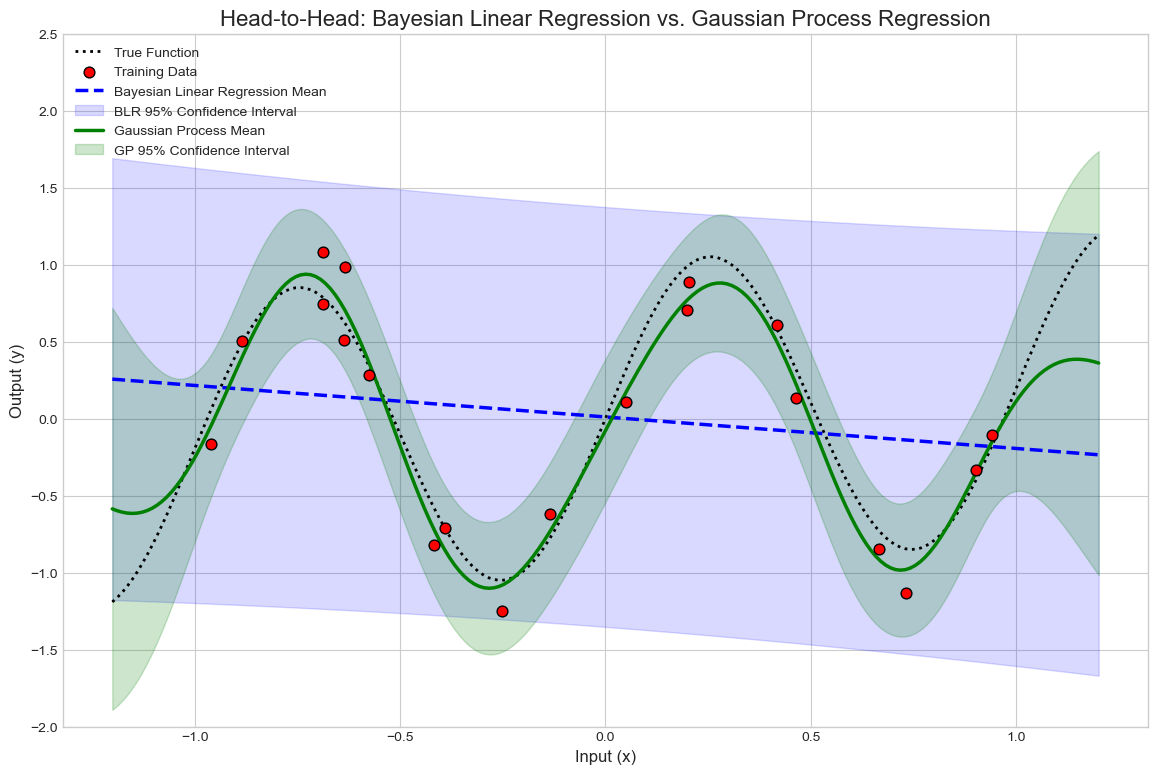

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

# --- 1. 生成模拟数据 (完全相同) ---
def true_function(x):
    return np.sin(x * 2 * np.pi) + 0.2 * x

np.random.seed(42)
n_samples = 20
X_train = np.random.rand(n_samples) * 2 - 1
y_train = true_function(X_train) + np.random.randn(n_samples) * 0.2

X_test = np.linspace(-1.2, 1.2, 200).reshape(-1, 1) # 确保是2D数组

# --- 2. 训练两个模型 ---

# a) 贝叶斯线性回归
bayesian_reg = BayesianRidge()
bayesian_reg.fit(X_train.reshape(-1, 1), y_train)
y_pred_br, y_std_br = bayesian_reg.predict(X_test, return_std=True)

# b) 高斯过程回归
kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp_model.fit(X_train.reshape(-1, 1), y_train)
y_pred_gp, y_std_gp = gp_model.predict(X_test, return_std=True)

# --- 3. 在同一张图上进行对比可视化 ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 9))

# --- 绘制基础元素 ---
# 绘制真实函数
plt.plot(X_test, true_function(X_test.flatten()), 'k:', linewidth=2, label='True Function')
# 绘制训练数据点
plt.scatter(X_train, y_train, c='red', s=60, zorder=10, edgecolors=(0, 0, 0), label='Training Data')

# --- 绘制贝叶斯线性回归的结果 ---
# 预测均值线
plt.plot(X_test, y_pred_br, color='blue', linewidth=2.5, linestyle='--', label='Bayesian Linear Regression Mean')
# 不确定性区间
plt.fill_between(X_test.flatten(), y_pred_br - 1.96 * y_std_br, y_pred_br + 1.96 * y_std_br,
                 color='blue', alpha=0.15, label='BLR 95% Confidence Interval')

# --- 绘制高斯过程回归的结果 ---
# 预测均值线
plt.plot(X_test, y_pred_gp, color='green', linewidth=2.5, label='Gaussian Process Mean')
# 不确定性区间
plt.fill_between(X_test.flatten(), y_pred_gp - 1.96 * y_std_gp, y_pred_gp + 1.96 * y_std_gp,
                 color='green', alpha=0.2, label='GP 95% Confidence Interval')

# --- 图表美化 ---
plt.title('Head-to-Head: Bayesian Linear Regression vs. Gaussian Process Regression', fontsize=16)
plt.xlabel('Input (x)', fontsize=12)
plt.ylabel('Output (y)', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.ylim(-2, 2.5) # 调整y轴范围以获得更好的视图
plt.show()

这张对比图将两种模型的哲学差异展现得淋漓尽致：

模型的灵活性 (Flexibility)：
贝叶斯线性回归（蓝色虚线） 严格地保持了线性的“偏见”。它无法弯曲自己去适应数据的非线性模式，只能给出一个总体的、平均的线性趋势。
高斯过程回归（绿色实线） 则展现了惊人的灵活性。它没有预设任何函数形式，而是像一条“柔性尺”一样，平滑地穿过了数据点，完美地捕捉了底层的非线性正弦波趋势。
不确定性的表达 (Uncertainty Quantification)：
贝叶斯线性回归（蓝色阴影） 的不确定性区间像一个宽度固定的“管道”。它表达的是对整条直线位置的不确定性，而不是对空间中不同区域预测能力的不确定性。
高斯过程回归（绿色阴GEO） 的不确定性区间是动态变化的。它清晰地告诉我们：
在有数据支撑的区域，我非常自信（阴影很窄）。
在远离数据的未知区域，我的自信心迅速下降（阴影变宽）。这是一种更智能、更符合现实的不确定性表达。

结论：

这张图清晰地告诉我们：
贝叶斯线性回归 是一个强假设 (Strong Assumption) 的模型。它假设世界是线性的，然后在这个假设下，严谨地量化了参数的不确定性。
高斯过程回归 是一个弱假设 (Weak Assumption) 的模型。它只假设世界是平滑的，然后让数据自己去“说”函数应该长什么样，并给出了一个随位置变化的、更精细的置信度评估。
在数学建模中，当你面对一个你不知道其内在机理的复杂问题时，高斯过程回归这种非参数化的、数据驱动的方法，往往是比强行套用一个简单（如线性）参数化模型更强大、更诚实的选择。